In [1]:
from astropy.io import fits
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
spec_dir = os.path.abspath('./../../spec/')+'/'
figs_dir = os.path.abspath('./../../figures')
# import ipynbname
# nb_path = str(ipynbname.path())
# spec_dir = os.path.join(os.path.abspath(nb_path + '/../../../'), 'spec/')

fits_path_36 = spec_dir+'order36/jun02s*'
fits_path_35 = spec_dir+'order35/jun02s*'
fits_path_37 = spec_dir+'order37/jun02s*'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_file(path=fits_path_36)
order35_data = rhp.read_file(path=fits_path_35)
order37_data = rhp.read_file(path=fits_path_37)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

avg_flat_order35 = rhp.calc_avg(data=order35_data, start=flat0, stop=flat1, init=int0)
avg_dark_order35 = rhp.calc_avg(data=order35_data, start=dark0, stop=dark1, init=int0)

avg_flat_order37 = rhp.calc_avg(data=order37_data, start=flat0, stop=flat1, init=int0)
avg_dark_order37 = rhp.calc_avg(data=order37_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []
spec35_reducelist = []
spec37_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe35 = rhp.scale_sky_frame(data=order35_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe37 = rhp.scale_sky_frame(data=order37_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
        
        reduce_spec35 = (order35_data[fn-int0] - skyframe35) / (avg_flat_order35 - avg_dark_order35)
        reduce_spec35[reduce_spec35<0] = 0
#         reduce_spec35 = np.delete(reduce_spec35, np.s_[:8], 0)
        
        reduce_spec37 = (order37_data[fn-int0] - skyframe37) / (avg_flat_order37 - avg_dark_order37)
        reduce_spec37[reduce_spec37<0] = 0
#         reduce_spec37 = np.vstack((reduce_spec37, np.zeros((7, 1024))))
    
        spec36_reducelist.append(reduce_spec36)
        spec35_reducelist.append(reduce_spec35)
        spec37_reducelist.append(reduce_spec37)
        
spec36_reduced = np.array(spec36_reducelist)
spec35_reduced = np.array(spec35_reducelist)
spec37_reduced = np.array(spec37_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange35 = fits.open(spec_dir + 'order35/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange37 = fits.open(spec_dir + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R35 = 73234.23454151815
R37 = 72736.04543958924
R = np.mean((R36,R35,R37))

# star flux calibration
modeA36 = order36_data[104-int0] + order36_data[107-int0] +\
        order36_data[108-int0] + order36_data[111-int0]
modeB36 = order36_data[105-int0] + order36_data[106-int0] +\
        order36_data[109-int0] + order36_data[110-int0]

modeA35 = order35_data[104-int0] + order35_data[107-int0] +\
        order35_data[108-int0] + order35_data[111-int0]
modeB35 = order35_data[105-int0] + order35_data[106-int0] +\
        order35_data[109-int0] + order35_data[110-int0]

modeA37 = order37_data[104-int0] + order37_data[107-int0] +\
        order37_data[108-int0] + order37_data[111-int0]
modeB37 = order37_data[105-int0] + order37_data[106-int0] +\
        order37_data[109-int0] + order37_data[110-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

modeAB35 = ((modeA35 - modeB35)/4)/(avg_flat_order35 - avg_dark_order35)/exp_star

modeAB37 = ((modeA37 - modeB37)/4)/(avg_flat_order37 - avg_dark_order37)/exp_star

flux36_model = Model(rhp.gaussian_fit)
flux35_model = Model(rhp.gaussian_fit)
flux37_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.003, min=0, max=0.01)
flux36_params.add('a1', value=36)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

flux35_params = flux35_model.make_params()
flux35_params.add('a0', value=0.003, min=0, max=0.01)
flux35_params.add('a1', value=42)
flux35_params.add('a2', value=2, min=0.5, max=5)
flux35_params.add('a3', value=0)
flux35_params.add('a4', value=0)
flux35_params.add('a5', value=0)

flux37_params = flux37_model.make_params()
flux37_params.add('a0', value=0.003, min=0, max=0.01)
flux37_params.add('a1', value=38)
flux37_params.add('a2', value=2, min=0.5, max=5)
flux37_params.add('a3', value=0)
flux37_params.add('a4', value=0)
flux37_params.add('a5', value=0)

lower = 0
upper = 1024

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

star35_a0 = np.zeros(np.size(modeAB35,1))
star35_a2 = np.zeros(np.size(modeAB35,1))

star37_a0 = np.zeros(np.size(modeAB37,1))
star37_a2 = np.zeros(np.size(modeAB37,1))

spat_ax36 = np.linspace(0, modeAB36.shape[0]-1, modeAB36.shape[0])
spat_ax35 = np.linspace(0, modeAB35.shape[0]-1, modeAB35.shape[0])
spat_ax37 = np.linspace(0, modeAB37.shape[0]-1, modeAB37.shape[0])

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    try:
        flux35_fit_result = flux35_model.fit(modeAB35.T[i], flux35_params, x=spat_ax35)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order35')
        
    try:
        flux37_fit_result = flux37_model.fit(modeAB37.T[i], flux37_params, x=spat_ax37)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order37')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
    star35_a0[i] = flux35_fit_result.params['a0'].value
    star35_a2[i] = flux35_fit_result.params['a2'].value
    
    star37_a0[i] = flux37_fit_result.params['a0'].value
    star37_a2[i] = flux37_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

Fbb35 = F_a0 * ((lambda_aw/waverange35)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange35*T)) - 1))

Fbb37 = F_a0 * ((lambda_aw/waverange37)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange37*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

star35_fwhm = star35_a2*(np.sqrt(2*np.log(2))*2)
Fobs35 = star35_a0 * star35_fwhm

star37_fwhm = star37_a2*(np.sqrt(2*np.log(2))*2)
Fobs37 = star37_a0 * star37_fwhm

Fc36 = Fbb36/Fobs36

Fc35 = Fbb35/Fobs35

Fc37 = Fbb37/Fobs37

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

width35 = spec35_reduced.shape[1]
length35 = spec35_reduced.shape[2]

width37 = spec37_reduced.shape[1]
length37 = spec37_reduced.shape[2]

slit_area36 = 0.288 * width36 * 2.908e-5 * length36

slit_area35 = 0.288 * width35 * 2.999e-5 * length35

slit_area37 = 0.288 * width37 * 2.859e-5 * length37

exp_spec = 60

fjc36_list = []
fjc35_list = []
fjc37_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc35_list.append(spec35_reduced[i] / exp_spec * Fc35 * 4.2535e10 / slit_area35)
    fjc37_list.append(spec37_reduced[i] / exp_spec * Fc37 * 4.2535e10 / slit_area37)
    
fjc36 = np.array(fjc36_list)
fjc35 = np.array(fjc35_list)
fjc37 = np.array(fjc37_list)


# rescale spatial axis
RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

pix_diff_star36 = np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
    np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

pix_diff_star35 = np.where(modeAB35.T[200]==np.min(modeAB35.T[200]))[0][0] -\
    np.where(modeAB35.T[200]==np.max(modeAB35.T[200]))[0][0]

pix_diff_star37 = np.where(modeAB37.T[200]==np.min(modeAB37.T[200]))[0][0] -\
    np.where(modeAB37.T[200]==np.max(modeAB37.T[200]))[0][0]

zoom_fac36 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star36
zoom_fac35 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star35
zoom_fac37 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star37

fjc36_rs = scipy.ndimage.zoom(fjc36, [1,zoom_fac36,1], mode='nearest')
fjc35_rs = scipy.ndimage.zoom(fjc35, [1,zoom_fac35,1], mode='nearest')
fjc37_rs = scipy.ndimage.zoom(fjc37, [1,zoom_fac37,1], mode='nearest')

fjc36_rs = np.delete(fjc36_rs, np.s_[260:], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[:14], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[260:], 1)

st_list = []

for i in range(fjc36_rs.shape[0]):
    s1a = np.delete(fjc36_rs[i], np.s_[439:], 1)
    s1b = np.delete(s1a, np.s_[:399], 1)
    s1b = scipy.ndimage.shift(s1b, -0.454378, order=3, mode='nearest')
    # y:1:n:0

#     s2a = np.delete(fjc32[i], np.s_[221:], 1)
#     s2b = np.delete(s2a, np.s_[:181], 1)
#     s2b = scipy.ndimage.shift(s2b, 5.530339, order=3, mode='nearest')
    # y:1:n:1

    s3a = np.delete(fjc36_rs[i], np.s_[539:], 1)
    s3b = np.delete(s3a, np.s_[:499], 1)
    s3b = scipy.ndimage.shift(s3b, -0.076430, order=3, mode='nearest')
    # y:2:n:1

#     s4a = np.delete(fjc36_rs[i], np.s_[669:], 1)
#     s4b = np.delete(s4a, np.s_[:629], 1)
#     s4b = scipy.ndimage.shift(s4b, 0.234528, order=3, mode='nearest')
    # y:2:n:2

#     s5a = np.delete(fjc36_rs[i], np.s_[873:], 1)
#     s5b = np.delete(s5a, np.s_[:833], 1)
#     s5b = scipy.ndimage.shift(s5b, 0.378369, order=3, mode='nearest')
    # y:2:n:3

    s6a = np.delete(fjc36_rs[i], np.s_[140:], 1)
    s6b = np.delete(s6a, np.s_[:100], 1)
    s6b = scipy.ndimage.shift(s6b, 15.041735, order=3, mode='nearest')
    # y:3:n:3

    s7a = np.delete(fjc37_rs[i], np.s_[443:], 1)
    s7b = np.delete(s7a, np.s_[:403], 1)
    s7b = scipy.ndimage.shift(s7b, -3.293717, order=3, mode='nearest')
    # y:4:n:3

    s8a = np.delete(fjc35_rs[i], np.s_[532:], 1)
    s8b = np.delete(s8a, np.s_[:492], 1)
    s8b = scipy.ndimage.shift(s8b, 0.235798, order=3, mode='nearest')
    # y:5:n:3

    s9a = np.delete(fjc36_rs[i], np.s_[86:], 1)
    s9b = np.delete(s9a, np.s_[:46], 1)
    s9b = scipy.ndimage.shift(s9b, 0.155569, order=3, mode='nearest')
    # y:6:n:3

    s10a = np.delete(fjc36_rs[i], np.s_[323:], 1)
    s10b = np.delete(s10a, np.s_[:283], 1)
    s10b = scipy.ndimage.shift(s10b, 10.464537, order=3, mode='nearest')
    # y:7:n:3

    s11a = np.delete(fjc35_rs[i], np.s_[185:], 1)
    s11b = np.delete(s11a, np.s_[:145], 1)
    s11b = scipy.ndimage.shift(s11b, -0.288932, order=3, mode='nearest')
    # y:8:n:3

    s12a = np.delete(fjc35_rs[i], np.s_[811:], 1)
    s12b = np.delete(s12a, np.s_[:771], 1)
    s12b = scipy.ndimage.shift(s12b, -0.489157, order=3, mode='nearest')
    # y:9:n:3

#     s13a = np.delete(fjc36_rs[i], np.s_[915:], 1)
#     s13b = np.delete(s13a, np.s_[:875], 1)
#     s13b = scipy.ndimage.shift(s13b, -0.523155, order=3, mode='nearest')
    # y:9:n:4

    s14a = np.delete(fjc35_rs[i], np.s_[727:], 1)
    s14b = np.delete(s14a, np.s_[:687], 1)
    s14b = scipy.ndimage.shift(s14b, -6.983206, order=3, mode='nearest')
    # y:10:n:4

    s15a = np.delete(fjc37_rs[i], np.s_[510:], 1)
    s15b = np.delete(s15a, np.s_[:470], 1)
    s15b = scipy.ndimage.shift(s15b, -0.570506, order=3, mode='nearest')
    # y:11:n:4

#     s16a = np.delete(fjc37_rs[i], np.s_[928:], 1)
#     s16b = np.delete(s16a, np.s_[:888], 1)
#     s16b = scipy.ndimage.shift(s16b, -5.808544, order=3, mode='nearest')
    # y:11:n:5

#     s17a = np.delete(fjc34[i], np.s_[411:], 1)
#     s17b = np.delete(s17a, np.s_[:371], 1)
#     s17b = scipy.ndimage.shift(s17b, -0.883871, order=3, mode='nearest')
    # y:11:n:6
    
#     stt = s1b+s2b+s3b+s4b+s5b+s6b+s7b+s8b+s9b+s10b+s11b+s12b+s13b+s14b+s15b+s16b+s17b
    stt = s1b+s3b+s6b+s7b+s8b+s9b+s10b+s11b+s12b+s14b+s15b
    # smooth along spatial axis - rolling stack of 5 pixels 
#     smoo = []
#     for j in range(2, len(stt)-2):
#         addup = np.mean((stt[j-2],stt[j-1],stt[j],stt[j+1],stt[j+2]), axis=0)
#         smoo.append(addup)
#     smooth = np.array(smoo)
    
    st_list.append(stt)

st = np.array(st_list)

In [ ]:
s9a = np.delete(fjc36_rs[i], np.s_[86:], 1)
s9b = np.delete(s9a, np.s_[:46], 1)
s9b = scipy.ndimage.shift(s9b, 0.155569, order=3, mode='nearest')

s6a = np.delete(fjc36_rs[i], np.s_[140:], 1)
s6b = np.delete(s6a, np.s_[:100], 1)
s6b = scipy.ndimage.shift(s6b, 15.041735, order=3, mode='nearest')

s10a = np.delete(fjc36_rs[i], np.s_[323:], 1)
s10b = np.delete(s10a, np.s_[:283], 1)
s10b = scipy.ndimage.shift(s10b, 10.464537, order=3, mode='nearest')

s1a = np.delete(fjc36_rs[i], np.s_[439:], 1)
s1b = np.delete(s1a, np.s_[:399], 1)
s1b = scipy.ndimage.shift(s1b, -0.454378, order=3, mode='nearest')

s3a = np.delete(fjc36_rs[i], np.s_[539:], 1)
s3b = np.delete(s3a, np.s_[:499], 1)
s3b = scipy.ndimage.shift(s3b, -0.076430, order=3, mode='nearest')

In [ ]:
s11a = np.delete(fjc35_rs[i], np.s_[185:], 1)
s11b = np.delete(s11a, np.s_[:145], 1)
s11b = scipy.ndimage.shift(s11b, -0.288932, order=3, mode='nearest')

s8a = np.delete(fjc35_rs[i], np.s_[532:], 1)
s8b = np.delete(s8a, np.s_[:492], 1)
s8b = scipy.ndimage.shift(s8b, 0.235798, order=3, mode='nearest')

s14a = np.delete(fjc35_rs[i], np.s_[727:], 1)
s14b = np.delete(s14a, np.s_[:687], 1)
s14b = scipy.ndimage.shift(s14b, -6.983206, order=3, mode='nearest')

s12a = np.delete(fjc35_rs[i], np.s_[811:], 1)
s12b = np.delete(s12a, np.s_[:771], 1)
s12b = scipy.ndimage.shift(s12b, -0.489157, order=3, mode='nearest')

In [ ]:
s7a = np.delete(fjc37_rs[i], np.s_[443:], 1)
s7b = np.delete(s7a, np.s_[:403], 1)
s7b = scipy.ndimage.shift(s7b, -3.293717, order=3, mode='nearest')

s15a = np.delete(fjc37_rs[i], np.s_[510:], 1)
s15b = np.delete(s15a, np.s_[:470], 1)
s15b = scipy.ndimage.shift(s15b, -0.570506, order=3, mode='nearest')

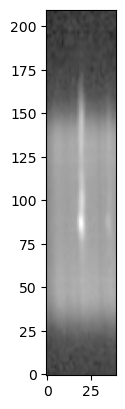

In [215]:
fjc36_rs[1][30:240,:1001]

s4a = np.delete(fjc36_rs[1], np.s_[669:], 1)
s4b = np.delete(s4a, np.s_[:629], 1)
s4b = scipy.ndimage.shift(s4b, 0.234528, order=3, mode='nearest')
    # y:2:n:2

fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(s4b[30:240,:], aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
# plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
# plt.ticklabel_format(useOffset=False)

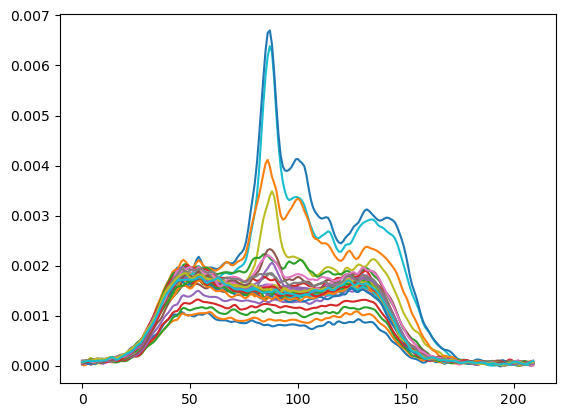

In [216]:
plt.plot(s4b[30:240,:])

Text(2.20299, 0.005, '12')

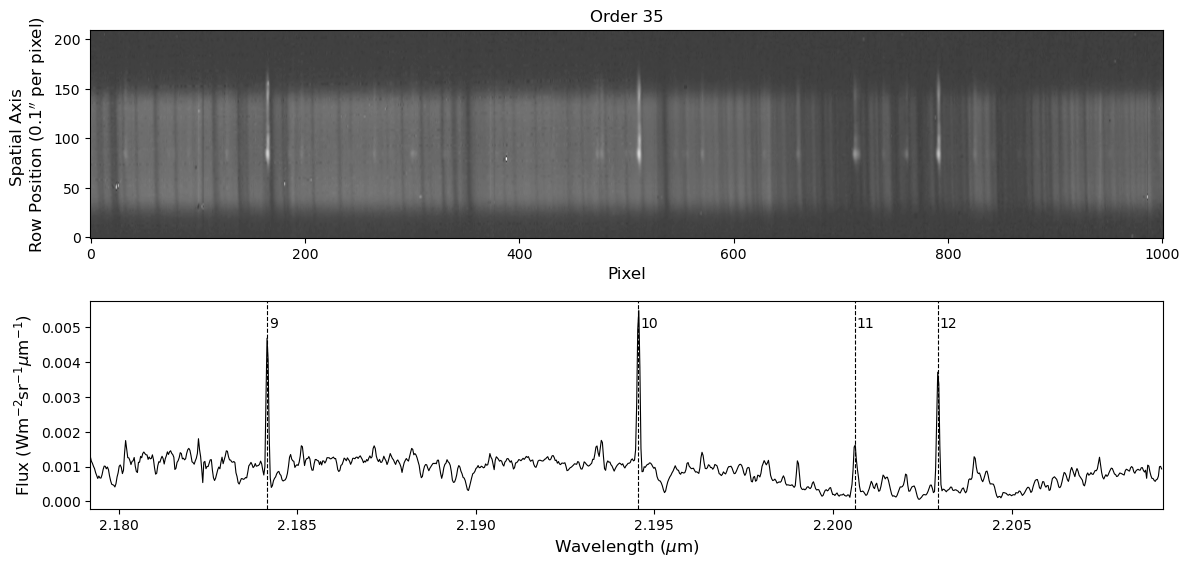

In [211]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc35_rs[1][30:240,:1001],
#            extent=[waverange35[0],waverange35[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 35', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange35[:1001], fjc35_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange35[0], waverange35[1001])
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

# plt.xlim(2.2025,2.2035)
plt.axvline(2.18416, color='k', ls='--', lw=0.8)
plt.axvline(2.19455, color='k', ls='--', lw=0.8)
plt.axvline(2.20061, color='k', ls='--', lw=0.8)
plt.axvline(2.20294, color='k', ls='--', lw=0.8)

plt.text(2.18421,0.005, '9')
plt.text(2.1946,0.005, '10')
plt.text(2.20066,0.005, '11')
plt.text(2.20299,0.005, '12')

Text(2.13433, 0.0085, '8')

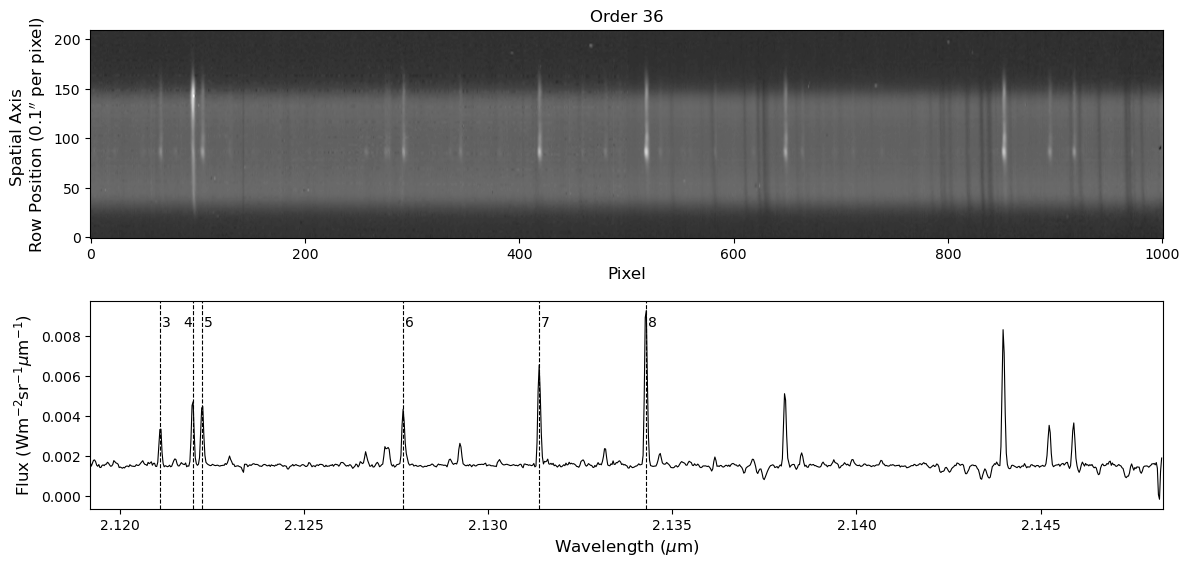

In [220]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc36_rs[1][30:240,:1001],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 36', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange36[:1001], fjc36_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange36[0], waverange36[1001])
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

# plt.xlim(2.1342,2.1344)

plt.axvline(2.1211, color='k', ls='--', lw=0.8)
plt.axvline(2.12198, color='k', ls='--', lw=0.8)
plt.axvline(2.122245, color='k', ls='--', lw=0.8)
plt.axvline(2.1277, color='k', ls='--', lw=0.8)
plt.axvline(2.13139, color='k', ls='--', lw=0.8)
plt.axvline(2.13428, color='k', ls='--', lw=0.8)

plt.text(2.12115,0.0085, '3')
plt.text(2.12173,0.0085, '4')
plt.text(2.122295,0.0085, '5')
plt.text(2.12775,0.0085, '6')
plt.text(2.13144,0.0085, '7')
plt.text(2.13433,0.0085, '8')

In [1]:
import h3ppy

# Create the H3+ object
h3p = h3ppy.h3p()
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
# wave = h3p.wavegen(3.94, 4.03, 1024)
wave = waverange36[:1001]

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h3p.model(density = 1e17, temperature = 1000, R = R36/3, wavelength = wave)
model2 = h2.model(density = 3e25, temperature = 1000, R = R36/3, wavelength = wave)

# Plot the model
fig, ax = plt.subplots()
# ax.plot(wave, model)
# ax.plot(wave, model2)
ax.plot(waverange36[:1001], fjc36_rs[1][30:240,:1001][90],'k', lw=0.8)
ax.set_xlim(waverange36[0], waverange36[1001])
# Automagically set the labels 
ax.set_xlabel(h3p.xlabel())
ax.set_ylabel(h3p.ylabel())
# plt.savefig('example_model.png')
# plt.close() 

NameError: name 'waverange36' is not defined

In [ ]:
h3p = h3ppy.h3p()

# Plot the observation
title = 'Keck NIRSPEC H$_3^+$ spectrum of the southern aurora of Jupiter'
fig, ax = plt.subplots()
ax.plot(wave, spec * 1e3)
ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), title = title)

Text(2.07635, 0.025, '2')

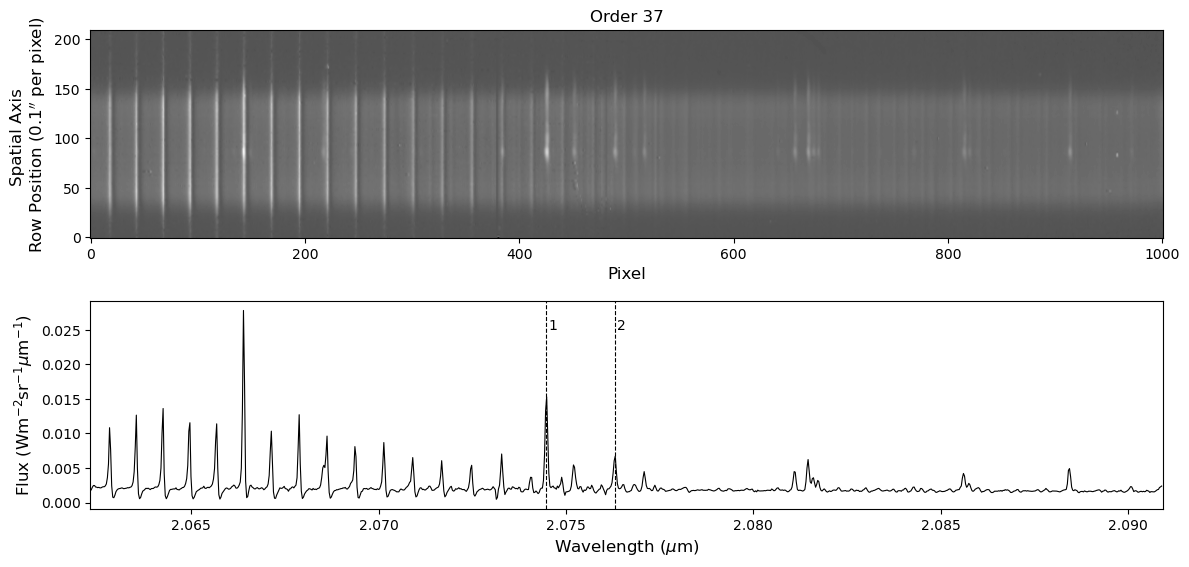

In [232]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc37_rs[1][30:240,:1001],
#            extent=[waverange37[0],waverange37[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 37', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange37[:1001], fjc37_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange37[0], waverange37[1001])
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

# plt.xlim(2.0761,2.0765)

plt.axvline(2.07448, color='k', ls='--', lw=0.8)
plt.axvline(2.0763, color='k', ls='--', lw=0.8)

plt.text(2.07453,0.025, '1')
plt.text(2.07635,0.025, '2')

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 40
    # variables        = 6
    chi-square         = 2.7028e-04
    reduced chi-square = 7.9494e-06
    Akaike info crit   = -464.197238
    Bayesian info crit = -454.063961
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
    a1:  at initial value
    a2:  at initial value
[[Variables]]
    a0:  0.01520000 (init = 0.0152)
    a1:  20745.0000 (init = 20745)
    a2:  1.00000000 (init = 1)
    a3:  58.6660865 (init = 0)
    a4: -0.00553913 (init = 0)
    a5:  1.3069e-07 (init = 0)
20745.0


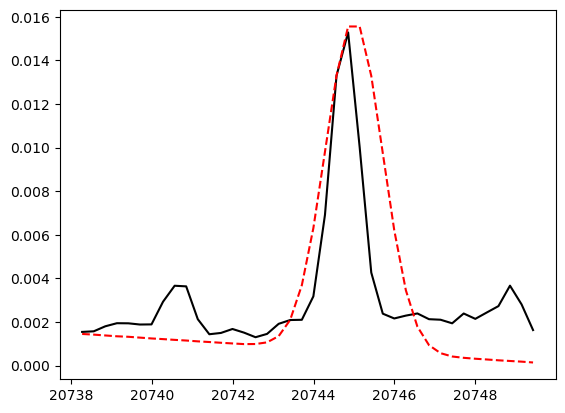

In [236]:
xx = waverange37[403:443]*1e4
y = fjc37_rs[1][30:240,403:443][90]

# create lmfit model with defined gaussian
g1_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=0.0152)
g1_params.add('a1', value=20745)
g1_params.add('a2', value=1)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(y, g1_params, x=xx)
except ValueError:
    print('ValueError occured')

print(g1_result.fit_report())

plt.plot(xx, y, 'k')
plt.plot(xx, g1_result.best_fit, 'r--', label='g1 best fit')
# # plt.xlim(2.13,2.135)

print(g1_result.params['a1'].value)

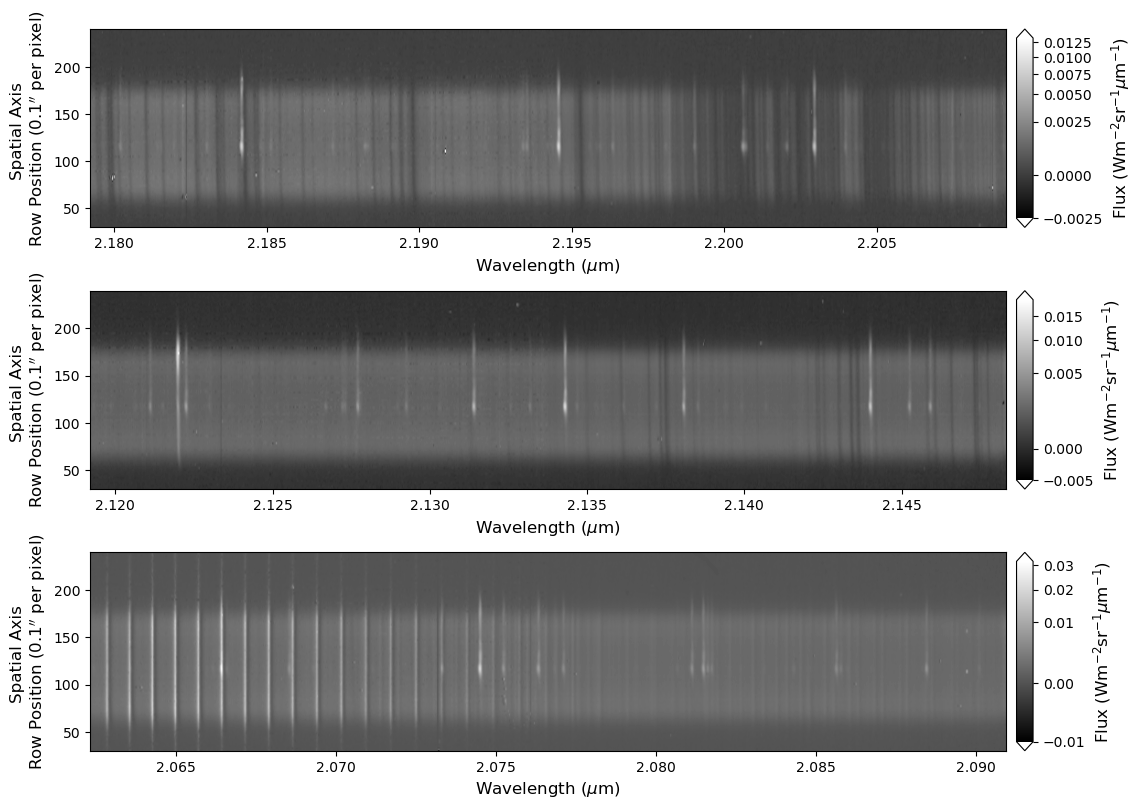

In [37]:
# t35 = np.delete(fjc35_rs, np.s_[:14], 1)
# t35 = np.delete(t35, np.s_[260:], 1)

# t37 = fjc37_rs
# t36 = np.delete(fjc36_rs, np.s_[260:], 1)

fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc35_rs[1][30:240,:1001],
           extent=[waverange35[0],waverange35[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.999 \times 10^{-5} \mathrm{\mu}$m / pixel)', fontsize=12)
plt.colorbar(extend='both', 
             aspect=12, 
             pad=0.01).set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=12)

fig.add_subplot(312)
plt.imshow(fjc36_rs[1][30:240,:1001],
           extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mathrm{\mu}$m / pixel)', fontsize=12)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mathrm{\mu}$m / pixel)', fontsize=12)
plt.colorbar(extend='both', 
             aspect=12, 
             pad=0.01).set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=12)
# plt.title('Flux Calibrated Spectra', fontsize=12)
# plt.savefig('flux_calibrated_spec', dpi=400, bbox_inches='tight', facecolor='white')

fig.add_subplot(313)
plt.imshow(fjc37_rs[1][30:240,:1001],
           extent=[waverange37[0],waverange37[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.859 \times 10^{-5} \mathrm{\mu}$m / pixel)', fontsize=12)
plt.colorbar(extend='both', 
             aspect=12, 
             pad=0.01).set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=12)

figs_dir = os.path.abspath('./../../figures')

plt.savefig(figs_dir+'/fig3b.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(figs_dir+'/fig3b.png', dpi=600, bbox_inches='tight', facecolor='white')

In [14]:
fjc37_rs[1][:,:1001].shape

(260, 1001)

In [23]:
zoom_fac36, zoom_fac35, zoom_fac37

(1.8932872511544623, 1.9228698644537507, 1.7835314684788413)

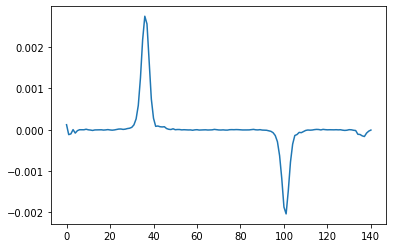

In [22]:
plt.plot(modeAB36.T[200])

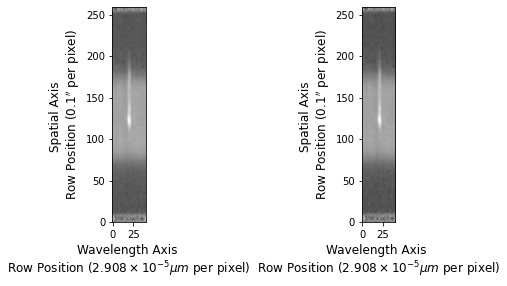

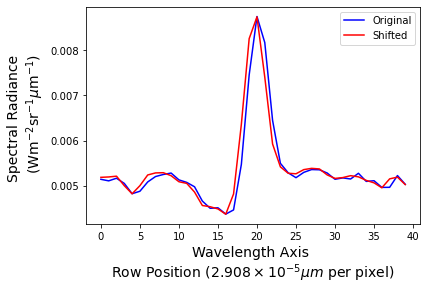

In [48]:
s1a = np.delete(fjc36_rs[0], np.s_[439:], 1)
s1b = np.delete(s1a, np.s_[:399], 1)
s1b2 = sp.ndimage.shift(s1b, -0.454378, order=3, mode='nearest')

s3a = np.delete(fjc36_rs[0], np.s_[539:], 1)
s3b = np.delete(s3a, np.s_[:499], 1)
s3b2 = sp.ndimage.shift(s3b, -0.076430, order=3, mode='nearest')

fig = plt.figure(figsize=(14,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(s1b, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=12)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.ticklabel_format(useOffset=False)

# fig.add_subplot(221)
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=12)

fig.add_subplot(221)
plt.imshow(s1b2, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=12)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.ticklabel_format(useOffset=False)

# plt.savefig('flux_calibrated_spec', dpi=400, bbox_inches='tight', facecolor='white')

plt.figure()
plt.plot(s1b[150], 'b-', label='Original')
plt.plot(s1b2[150], 'r-', label='Shifted')
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spectral Radiance \n (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=14)
plt.legend()

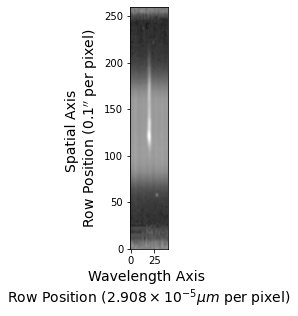

In [38]:
# spt = np.delete(st[0], np.s_[1000:], axis=1)
# x = waverange36[0:1000]

fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(st[0], aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ticklabel_format(useOffset=False)
# plt.title('a) Order 35 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
# plt.gca().invert_yaxis()

In [8]:
# extract H3+ properties by fitting gaussian curve to the emission lines
h3p_a0_map = []
h3p_a1_map = []
h3p_fwhm_map = []
h3p_a0_map_error = []
h3p_a1_map_error = []
h3p_fwhm_map_error = []


fn0 = 0
fn1 = np.size(st,0)

upper_h3p = 240
lower_h3p = 30

print('H3p LOOP START')
for fn in range(fn0, fn1):
    print('Frame Number = ' + str(fn))

    h3p_a0 = np.zeros(301)
    h3p_a1 = np.zeros(301)
    h3p_a2 = np.zeros(301)
    h3p_a0_error = np.zeros(301)
    h3p_a1_error = np.zeros(301)
    h3p_a2_error = np.zeros(301)
    
    stack = st[fn]
    
    pixel = np.linspace(0, np.size(stack,1)-1, np.size(stack,1))
    
    for i in range(lower_h3p, upper_h3p):
        # create lmfit model with defined gaussian
        h3p_model = Model(rhp.gaussian_fit)

        # create parameters and add initial guess
        h3p_params = h3p_model.make_params()
        h3p_params.add('a0', value=0.1, min=0, max=0.5)
        h3p_params.add('a1', value=20, min=17, max=23)
        h3p_params.add('a2', value=2, min=0, max=6)
        h3p_params.add('a3', value=0)
        h3p_params.add('a4', value=0)
        h3p_params.add('a5', value=0)
        
        # perform gaussian fit and test errors
        try:
            h3p_fit_result = h3p_model.fit(stack[i], h3p_params, x=pixel)
        except ValueError:
            print('ValueError occured at i=' + str(i))
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, stack[i])
            plt.plot(pixel, h3p_fit_result.best_fit, 'r-', label='best fit')
        
        # collect fitting parameters
        h3p_a0[i] = h3p_fit_result.params['a0'].value
        h3p_a1[i] = h3p_fit_result.params['a1'].value
        h3p_a2[i] = h3p_fit_result.params['a2'].value
        h3p_a0_error[i] = h3p_fit_result.params['a0'].stderr
        h3p_a1_error[i] = h3p_fit_result.params['a1'].stderr
        h3p_a2_error[i] = h3p_fit_result.params['a2'].stderr
        
    # collect fitting parameters of each frame number and calibrate errors
    h3p_a0_map.append(h3p_a0)
    h3p_a1_map.append(h3p_a1)
    h3p_fwhm_map.append(h3p_a2 * (np.sqrt(2*np.log(2))*2))
    
    h3p_a0_error[h3p_a0_error > 10] = 1e10
    h3p_a0_error[np.isnan(h3p_a0_error)] = 1e10
    h3p_a0_map_error.append(h3p_a0_error)
    
    
    h3p_a1_error[h3p_a1_error > 10] = 1e10
    h3p_a1_error[np.isnan(h3p_a1_error)] = 1e10
    h3p_a1_map_error.append(h3p_a1_error)
    
    h3p_a2_error[h3p_a2_error > 10] = 1e10
    h3p_a2_error[np.isnan(h3p_a2_error)] = 1e10  
    h3p_fwhm_map_error.append(h3p_a2_error * (np.sqrt(2*np.log(2))*2))
    
print('DONE')

H3p LOOP START
Frame Number = 0
Frame Number = 1
Frame Number = 2
Frame Number = 3
Frame Number = 4
Frame Number = 5
Frame Number = 6
Frame Number = 7
Frame Number = 8
Frame Number = 9
Frame Number = 10
Frame Number = 11
Frame Number = 12
Frame Number = 13
Frame Number = 14
Frame Number = 15
Frame Number = 16
Frame Number = 17
Frame Number = 18
Frame Number = 19
Frame Number = 20
Frame Number = 21
Frame Number = 22
Frame Number = 23
Frame Number = 24
Frame Number = 25
Frame Number = 26
Frame Number = 27
Frame Number = 28
Frame Number = 29
Frame Number = 30
Frame Number = 31
Frame Number = 32
Frame Number = 33
Frame Number = 34
Frame Number = 35
Frame Number = 36
Frame Number = 37
DONE


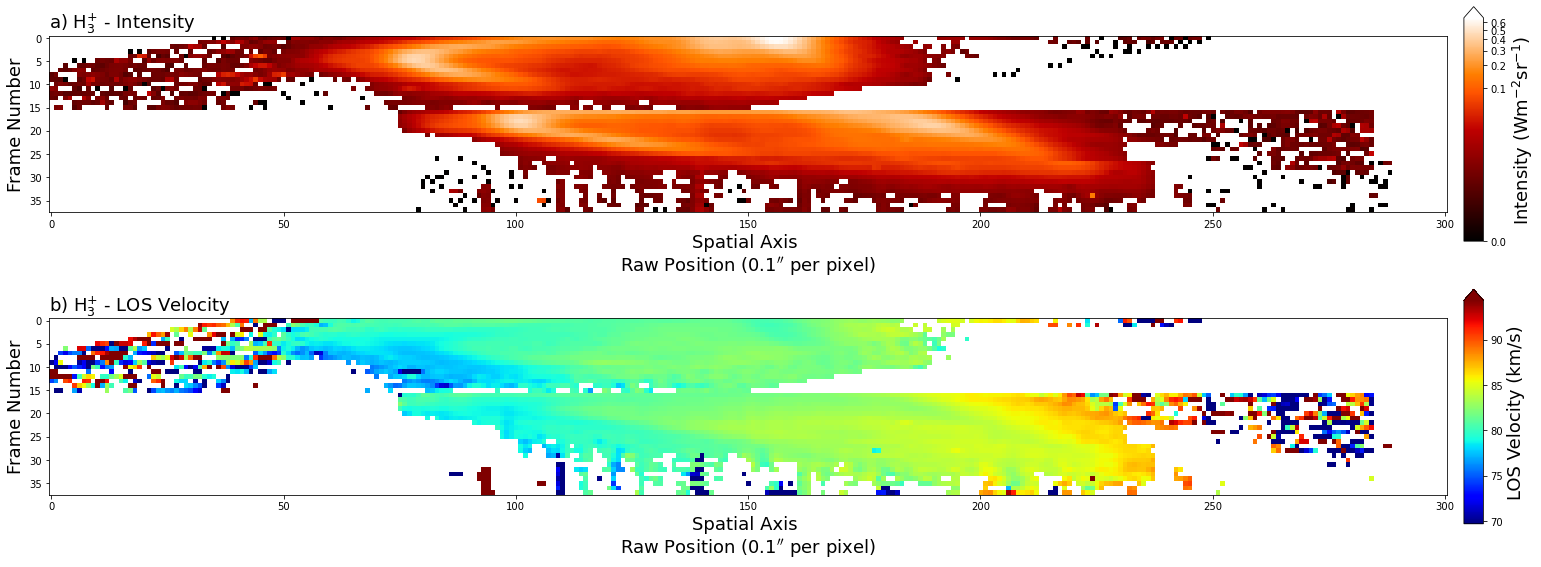

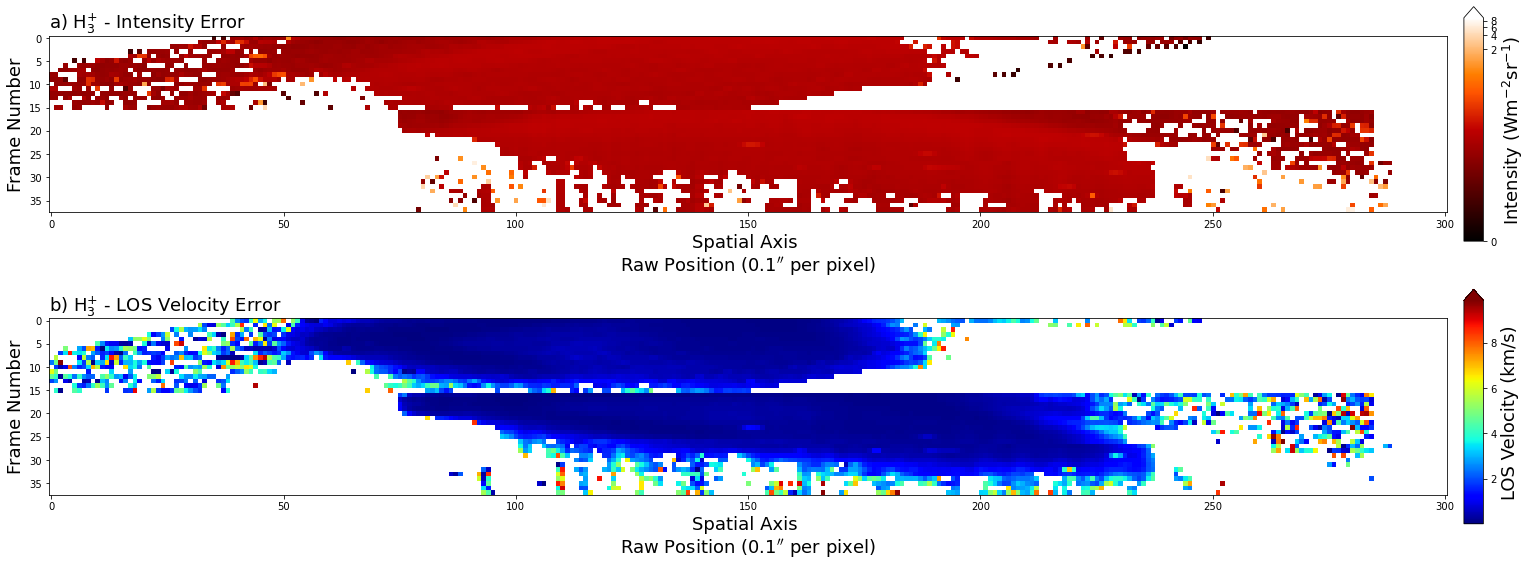

In [15]:
# data
h3p_a0 = np.vstack((h3p_a0_map))
h3p_a1 = np.vstack((h3p_a1_map))
h3p_fwhm = np.vstack((h3p_fwhm_map))

h3p_int = h3p_a0*h3p_fwhm
h3p_los = h3p_a1/R*3e5*np.cos(3.098*np.pi/180)

h3p_int1 = np.roll(h3p_int[:6], 23, axis=1)
h3p_int2 = np.roll(h3p_int[6:11], 22, axis=1)
h3p_int3 = np.roll(h3p_int[11:16], 30, axis=1)
h3p_int4 = np.roll(h3p_int[16:27], -14, axis=1)
h3p_int5 = np.roll(h3p_int[27:], -18, axis=1)
h3p_int_shifted = np.vstack((h3p_int1, h3p_int2, h3p_int3, h3p_int4, h3p_int5))

for i in range(16):
    h3p_int_shifted[i,:] = sp.ndimage.shift(h3p_int_shifted[i,:], i*6, order=5)

    
h3p_los1 = np.roll(h3p_los[:6], 23, axis=1)
h3p_los2 = np.roll(h3p_los[6:11], 22, axis=1)
h3p_los3 = np.roll(h3p_los[11:16], 30, axis=1)
h3p_los4 = np.roll(h3p_los[16:27], -14, axis=1)
h3p_los5 = np.roll(h3p_los[27:], -18, axis=1)
h3p_los_shifted = np.vstack((h3p_los1, h3p_los2, h3p_los3, h3p_los4, h3p_los5))

for i in range(16):
    h3p_los_shifted[i,:] = sp.ndimage.shift(h3p_los_shifted[i,:], i*6, order=5)

h3p_int_shifted = np.flip(h3p_int_shifted, 1)
h3p_los_shifted = np.flip(h3p_los_shifted, 1)

# error
h3p_a0_error = np.vstack((h3p_a0_map_error))
h3p_a1_error = np.vstack((h3p_a1_map_error))
h3p_fwhm_error = np.vstack((h3p_fwhm_map_error))

h3p_a0_error[h3p_a0_error==0]=1e10
h3p_a1_error[h3p_a1_error==0]=1e10
h3p_fwhm_error[h3p_fwhm_error==0]=1e10

h3p_a0[h3p_a0==0]=1e10
h3p_a1[h3p_a1==0]=1e10
h3p_fwhm[h3p_fwhm==0]=1e10

h3p_int_error = h3p_int*np.sqrt((h3p_a0_error/h3p_a0)**2+(h3p_fwhm_error/h3p_fwhm)**2)
h3p_los_error = h3p_a1_error/R*3e5*np.cos(3.098*np.pi/180)

h3p_int1_error = np.roll(h3p_int_error[:6], 23, axis=1)
h3p_int2_error = np.roll(h3p_int_error[6:11], 22, axis=1)
h3p_int3_error = np.roll(h3p_int_error[11:16], 30, axis=1)
h3p_int4_error = np.roll(h3p_int_error[16:27], -14, axis=1)
h3p_int5_error = np.roll(h3p_int_error[27:], -18, axis=1)
h3p_int_shifted_error = np.vstack((h3p_int1_error, h3p_int2_error, h3p_int3_error, h3p_int4_error, h3p_int5_error))

for i in range(16):
    h3p_int_shifted_error[i,:] = sp.ndimage.shift(h3p_int_shifted_error[i,:], i*6, order=5)

h3p_los1_error = np.roll(h3p_los_error[:6], 23, axis=1)
h3p_los2_error = np.roll(h3p_los_error[6:11], 22, axis=1)
h3p_los3_error = np.roll(h3p_los_error[11:16], 30, axis=1)
h3p_los4_error = np.roll(h3p_los_error[16:27], -14, axis=1)
h3p_los5_error = np.roll(h3p_los_error[27:], -18, axis=1)
h3p_los_shifted_error = np.vstack((h3p_los1_error, h3p_los2_error, h3p_los3_error, h3p_los4_error, h3p_los5_error))

for i in range(16):
    h3p_los_shifted_error[i,:] = sp.ndimage.shift(h3p_los_shifted_error[i,:], i*6, order=5)
    
h3p_int_shifted_error[h3p_int_shifted_error>=10] = np.nan
h3p_int_shifted_error[h3p_int_shifted_error<=1e-7] = np.nan
h3p_los_shifted_error[h3p_los_shifted_error>=10] = np.nan
h3p_los_shifted_error[h3p_los_shifted_error<=1e-7] = np.nan

h3p_int_shifted_error = np.flip(h3p_int_shifted_error, 1)
h3p_los_shifted_error = np.flip(h3p_los_shifted_error, 1)

h3p_int_shifted[np.isnan(h3p_int_shifted_error)] = np.nan
h3p_los_shifted[np.isnan(h3p_los_shifted_error)] = np.nan

# plot
fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h3p_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h3p_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h3p_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h3p_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

In [12]:
hdu1 = fits.PrimaryHDU(h3p_int_shifted)
hdu1.writeto('h3p_int_shifted.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_los_shifted)
hdu2.writeto('h3p_los_shifted.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h3p_int_shifted_error)
hdu3.writeto('h3p_int_shifted_error.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h3p_los_shifted_error)
hdu4.writeto('h3p_los_shifted_error.fits', overwrite=True)